In [8]:
import polars as pl
import matplotlib.pyplot as plt
from PIL import Image

# Dataset details

1. Download all figures from 100 Nature Genetics open access papers. 100 papers, 1033 figures
2. Label only figures that contain genomics visualization (292 images)

Note that many figures contain multiple sub figures. The dataset labels are of each track in each subfigure. 

# Import the image labels

The image labels are stored in a Parquet file. There are several important columns:

Each row is a different bounding box. 

- `img_name`: the name of the image file
- `label`: the label of the bounding box
- `x`, `y`, `w`, `h`: the bounding box coordinates

In [41]:
df = pl.read_parquet('nature_genetics_labels.parquet')
df

img_name,pmc_id,figure_name,label,height,width,x,y
str,str,str,str,f64,f64,f64,f64
"""10937405_Fig6.jpg""","""10937405""","""Fig6""","""simplified-gene""",3.187919,29.454093,26.029198,25.167785
"""10937405_Fig6.jpg""","""10937405""","""Fig6""","""simplified-gene""",3.020134,30.481561,26.029198,29.026846
"""10937405_Fig6.jpg""","""10937405""","""Fig6""","""simplified-gene""",3.008199,30.139071,25.98433,32.161524
"""10937405_Fig6.jpg""","""10937405""","""Fig6""","""simplified-gene""",3.020134,30.82405,25.686709,35.402685
"""10937405_Fig6.jpg""","""10937405""","""Fig6""","""simplified-gene""",3.027988,31.851519,25.686709,38.926174
…,…,…,…,…,…,…,…
"""7614755_F1.jpg""","""7614755""","""F1""","""manhattan (point)""",17.785235,96.534186,2.845218,0.671141
"""7614755_F1.jpg""","""7614755""","""F1""","""manhattan (point)""",16.442953,96.534186,3.465814,22.483221
"""7614755_F1.jpg""","""7614755""","""F1""","""manhattan (point)""",16.442953,96.534186,3.059354,42.95302


In [56]:
df['img_name'].unique()

img_name
str
"""10703697_Fig5.jpg"""
"""10703692_Fig1.jpg"""
"""10786727_Fig4.jpg"""
"""10937370_Fig1.jpg"""
"""10412458_Fig6.jpg"""
…
"""10703696_Fig4.jpg"""
"""10786724_Fig5.jpg"""
"""10335936_Fig13.jpg"""


Let's group the labels by image

In [55]:
# Would reccomend doing some cleaning of the labels. This cleans up the labels to be more general. 
# For the purpose of chart type labels, this is not needed. 
# It would be good to rename some of the labels like heatmap-track to heatmap.  
# convert = {
#     'sanger': 'line',
#     'aligned-peaks': 'line',
#     'distance': 'line',
#     'manhattan (point)': 'point',
#     'miami': 'point',
#     'logos (text)': 'text',
#     'multiple sequence alignment': 'text',
#     'heatmap-track': 'rect',
#     'aligned-reads': 'rect',
#     'stair-reads': 'rect',
#     'aligned-peak-heatmap': 'rect',
#     'heatmap-horizontal': 'heatmap',
#     'simplified-gene': 'genes',
#     'blank-ideogram': 'ideogram',
#     'circle-multi': 'circle',
#     'circle-withinLink': 'circle',
#     'area-link': 'area,withinLink',
#     'rect-link': 'rect,withinLink',
#     'discontinuous-grid': 'rect',
#     'lollipop': 'bar,point',
# }
# simplified_column = []

# for label in df['label']:
#     simplified = convert.get(label, label)
#     simplified_column.append(simplified)

# all_data_simplified = df.with_columns([pl.Series("simplified", simplified_column)])

# Here we group by the image name and maintain the order of the rows
grouped_imgs = df.partition_by(by='img_name', maintain_order=True, as_dict=True)

## Visualize the labels on the image

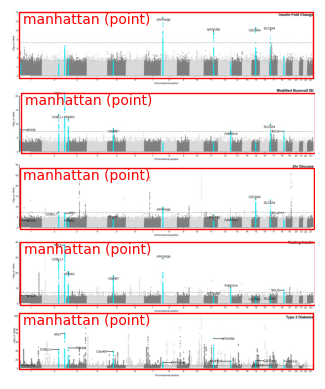

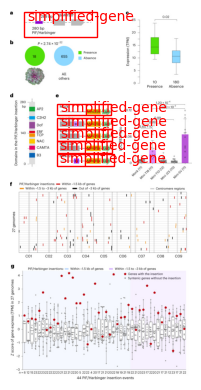

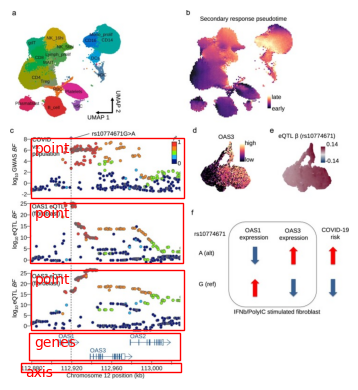

In [53]:
base_dir = "./images"

def show_labels(img_path: str):
    labels = grouped_imgs[(img_path,)]
    img = Image.open(f"{base_dir}/{img_path}")
    for row in labels.rows(named=True):
        label = row['label']
        x = row['x'] / 100 * img.width
        y = row['y'] / 100 * img.height
        width = row['width'] / 100 * img.width
        height = row['height'] / 100 * img.height
        # Draw bounding box on image
        plt.gca().add_patch(plt.Rectangle((x, y), width, height, edgecolor='r', facecolor='none'))
        plt.text(x + 10, y + 30, label, color='r', size=10)
    
    plt.imshow(img)
    plt.axis('off')
    plt.show()

show_labels('7614755_F1.jpg')
show_labels('10937405_Fig6.jpg')
show_labels('10260404_Fig13.jpg')

    